In [1]:
#importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
beer = pd.read_csv('data/recipeData.csv', index_col='BeerID', encoding='latin1')

In [3]:
beer['BeerID'] = beer.index

In [4]:
beer.shape

(73861, 22)

In [5]:
beer.head()

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,BeerID
BeerID,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,1
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,2
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,3
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,4
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,5


In [6]:
beer['StyleID'].nunique()

176

In [7]:
#What styles have the most data points?
stylecounts = pd.DataFrame(beer['Style'].value_counts().reset_index())
stylecounts.loc[stylecounts['Style']>400,:]


,index,Style
0,American IPA,11940
1,American Pale Ale,7581
2,Saison,2617
3,American Light Lager,2277
4,American Amber Ale,2038
5,Blonde Ale,1753
6,Imperial IPA,1478
7,American Stout,1268
8,Irish Red Ale,1204
9,American Brown Ale,1152


There are too many styles to make a strong model. I can experiment with different style groupings to figure out which work best in the model.

In [8]:
## Count nulls 
null_count = beer.isnull().sum()
null_count[null_count>0]

Name                 1
Style              596
BoilGravity       2990
MashThickness    29864
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
dtype: int64

'PrimingMethod','PrimingAmount'have over 90% nulls and I don't need 'URL', or 'Name'. I can drop them. To see if I can drop the other high-null columns I need to see how strong they correlate with other columns. 

In [9]:
beer.corr()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp,BeerID
StyleID,1.000000,-0.006522,0.002699,0.007336,0.006617,-0.141124,0.166669,-0.006301,0.077969,0.002326,0.021515,0.006167,0.079123,-0.019661,-0.074825
Size(L),-0.006522,1.000000,0.162237,0.141614,-0.013527,-0.029917,-0.018068,0.994143,0.044848,0.176071,0.108826,0.019246,0.026623,0.004278,0.001924
OG,0.002699,0.162237,1.000000,0.936347,0.029432,-0.001655,0.013632,0.165162,0.031825,0.968138,0.067610,0.046841,0.020556,0.000518,-0.024895
FG,0.007336,0.141614,0.936347,1.000000,0.026851,-0.000719,0.029848,0.142974,0.028930,0.908611,0.061173,0.040541,0.013446,0.004477,-0.030662
ABV,0.006617,-0.013527,0.029432,0.026851,1.000000,0.290889,0.271332,-0.009800,0.120629,0.025421,0.047853,-0.069633,0.132699,0.060065,-0.051921
IBU,-0.141124,-0.029917,-0.001655,-0.000719,0.290889,1.000000,0.060283,-0.028258,0.078694,-0.007498,-0.033172,-0.044381,0.006180,0.035510,-0.015845
Color,0.166669,-0.018068,0.013632,0.029848,0.271332,0.060283,1.000000,-0.016798,0.058089,0.013451,-0.017297,-0.038406,0.016061,0.025622,-0.046867
BoilSize,-0.006301,0.994143,0.165162,0.142974,-0.009800,-0.028258,-0.016798,1.000000,0.051219,0.175972,0.121971,0.017772,0.030936,0.003000,0.002819
BoilTime,0.077969,0.044848,0.031825,0.028930,0.120629,0.078694,0.058089,0.051219,1.000000,0.026921,0.161295,0.006850,0.190922,-0.079809,-0.044273
BoilGravity,0.002326,0.176071,0.968138,0.908611,0.025421,-0.007498,0.013451,0.175972,0.026921,1.000000,0.059132,0.050944,0.016216,0.002268,-0.031692


'OG','BoilGravity','BoilSize' are strongly correlated with other variables. I can drop them. I can keep the high-null columns for now.

In [10]:
# drop unnecessary and high-null columns
beer2 = beer.drop(columns = ['PrimingMethod','PrimingAmount','URL','Name','OG','BoilGravity','BoilSize'])

Now I'll try grouping the different styles into larger groups.I'll store them in their own columns.

In [11]:
v = beer2['IPA'] = (beer['Style'].str.contains(' IPA'))*'IPA'

In [12]:
d = beer2['Light Lager'] = (beer['Style'].str.contains('Light Lager'))*'Light '

In [13]:
o = beer2['Lager'] = (beer['Style'].str.contains(' Lager|Common |Steam '))*'Lager'

In [14]:
f = beer2['Pale Ale'] = (beer['Style'].str.contains('Saison|Strong Bitter|Pale Ale'))*'Pale Ales'

In [15]:
k = beer2['Stout-Porter'] = (beer['Style'].str.contains(' Stout| Porter'))*'Stout-Porter' 

In [16]:
q = beer2['Weissbier'] = (beer['Style'].str.contains('Witbier|Weissbier|Weizenbier|Weizen/Weissbier'))*'Weissbier'

In [17]:
#add new style groups to form 'kind' of beer column
beer2['kind'] = d+f+k+o+q+v+''
beer2['kind'].value_counts()
beer2['kind'].nunique()

7

In [18]:
def cut_beercols(df):
    df2 = pd.DataFrame(df.iloc[:,:-int(df['kind'].nunique())])
    df2['kind'] = df['kind']
    df2['kind'] =  df2['kind'].replace('',np.nan)
    print(df2['kind'].value_counts())
    return df2

In [19]:
#cut unnecessary style group columns
beer3 = cut_beercols(beer2)

IPA             17064
Pale Ales       11963
Stout-Porter     8654
Weissbier        3181
Lager            2969
Light Lager      2277
Name: kind, dtype: int64


In [20]:
beer3.head()

,Style,StyleID,Size(L),FG,ABV,IBU,Color,BoilTime,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,BeerID,kind
BeerID,,,,,,,,,,,,,,,,
1,Cream Ale,45,21.77,1.013,5.48,17.65,4.83,75,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,1,NaN
2,Holiday/Winter Special Spiced Beer,85,20.82,1.021,8.16,60.65,15.64,60,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,2,NaN
3,American IPA,7,18.93,1.018,5.91,59.25,8.98,60,70.0,NaN,Specific Gravity,extract,NaN,NaN,3,IPA
4,American IPA,7,22.71,1.017,5.80,54.48,8.50,60,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,4,IPA
5,Belgian Blond Ale,20,50.00,1.010,6.48,17.84,4.57,90,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,5,NaN


The nan counts for MashThickness, PitchRate and PrimaryTemp are fairly high. We can keep these features if they don't seem skewed toward one style or another.

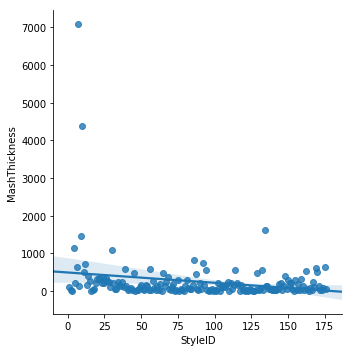

In [21]:
#Plot MashThickness value counts over StyleIDs.
beergroup = pd.DataFrame(beer3.groupby('StyleID')['MashThickness'].count().reset_index())
sns.lmplot(x = 'StyleID', y = 'MashThickness', data = beergroup)

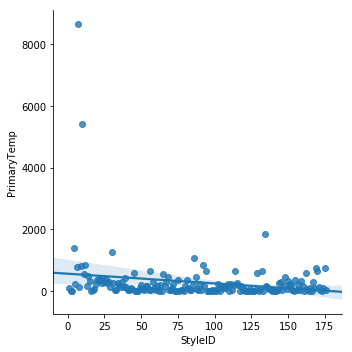

In [22]:
#Plot PrimaryTemp value counts over StyleIDs.
beergroup2 = pd.DataFrame(beer3.groupby('StyleID')['PrimaryTemp'].count().reset_index())
sns.lmplot(x = 'StyleID', y = 'PrimaryTemp', data = beergroup2)

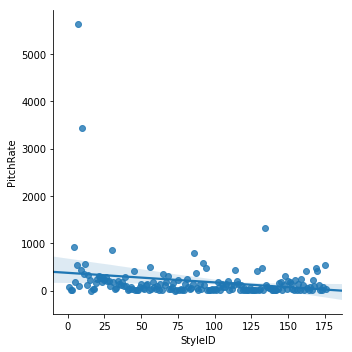

In [23]:
#Plot PitchRate value counts over StyleIDs.
beergroup3 = pd.DataFrame(beer3.groupby('StyleID')['PitchRate'].count().reset_index())
sns.lmplot(x = 'StyleID', y = 'PitchRate', data = beergroup3)

The data-points for all of these high-nan variables seem to be pretty consistent across styles. These columns could be useful. Now how do I fill nan? Let me check the distributions for each variable for each kind of beer.

In [24]:
beerind = beer3.set_index('kind')
beerind.index.unique()



Index([nan, 'IPA', 'Pale Ales', 'Stout-Porter', 'Lager', 'Weissbier',
       'Light Lager'],
      dtype='object', name='kind')

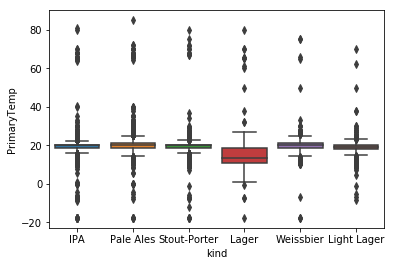

In [25]:
#boxplot of PrimaryTemp for each beer category
sns.boxplot(x =beerind.index, y = 'PrimaryTemp', data = beerind)

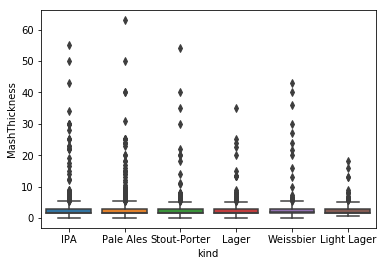

In [26]:
#boxplot of PrimaryTemp for each beer category
sns.boxplot(x =beerind.index, y = 'MashThickness', data = beerind)

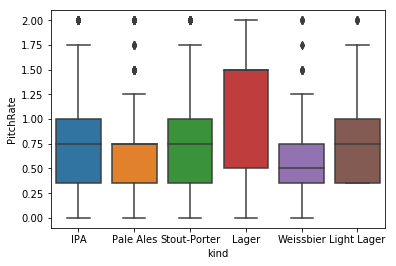

In [27]:
#boxplot of PrimaryTemp for each beer category
sns.boxplot(x =beerind.index, y = 'PitchRate', data = beerind)
#Median is probably best for PitchRate because of Pale Ales, and Weissbier. Otherwise I could use mean.

It looks like the best choice is to fill with the variable median for each category of beer, as there are a lot of outliers.

In [28]:
# make list of beers to iterate over
beerlist =list(beerind.index.unique())
beerlist.remove(np.nan)
beerlist

['IPA', 'Pale Ales', 'Stout-Porter', 'Lager', 'Weissbier', 'Light Lager']

In [29]:
#make list of column to iterate over
columnlist = ['PrimaryTemp','PitchRate','MashThickness']

In [30]:
def fill_median(df,columnlist,beerlist):
    for j in columnlist:
        fin = pd.DataFrame(None)
        for i in beerlist:
            df2 = df.set_index('kind')
            medians= pd.DataFrame(df2.loc[i,:].median(axis =0,numeric_only = True))
            result = df2.loc[i,:][[j,'BeerID']].fillna(int(medians.loc[j]))
            fin = pd.concat([fin,result])
        df = df.merge(fin, how = 'inner', on ='BeerID')
    df = df.drop(columns=['MashThickness_x','PitchRate_x','PrimaryTemp_x'])    
    return df

In [31]:
#fill variables nans with variable medians for each beer
beer4 = fill_median(beer3,columnlist,beerlist)

In [32]:
beer4.shape

(46108, 16)

In [33]:
beer4.head()

,Style,StyleID,Size(L),FG,ABV,IBU,Color,BoilTime,Efficiency,SugarScale,BrewMethod,BeerID,kind,PrimaryTemp_y,PitchRate_y,MashThickness_y
0,American IPA,7,18.93,1.018,5.91,59.25,8.98,60,70.0,Specific Gravity,extract,3,IPA,20.0,0.0,1.0
1,American IPA,7,22.71,1.017,5.80,54.48,8.50,60,70.0,Specific Gravity,All Grain,4,IPA,20.0,0.0,1.0
2,American Pale Ale,10,24.61,1.013,5.58,40.12,8.00,70,79.0,Specific Gravity,All Grain,6,Pale Ales,20.0,1.0,1.0
3,Imperial IPA,86,22.71,1.018,7.09,268.71,6.33,90,75.0,Specific Gravity,All Grain,7,IPA,20.0,0.0,1.0
4,Robust Porter,129,22.71,1.016,5.77,31.63,34.76,75,73.0,Specific Gravity,All Grain,9,Stout-Porter,20.0,0.0,1.0


Finally I can drop all the empty fields from the 'kind' column I created and see how many rows I have left.

In [34]:
beer4 = pd.DataFrame(beer4.dropna(how = 'any',axis = 0))

In [35]:
beer4.shape

(46108, 16)

Now I'll get_dummies to prepare for modeling.

In [36]:
beer4dum = pd.get_dummies(beer4.drop(columns = ['kind','Style','StyleID','BeerID']))

In [37]:
beer4dum.corr()

,Size(L),FG,ABV,IBU,Color,BoilTime,Efficiency,PrimaryTemp_y,PitchRate_y,MashThickness_y,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
Size(L),1.000000,0.145858,-0.011983,-0.037171,-0.015942,0.047806,0.112073,-0.006461,0.004494,0.056261,0.170789,-0.170789,0.091471,-0.058586,-0.026242,-0.048820
FG,0.145858,1.000000,0.030339,-0.003165,0.038722,0.031166,0.063970,-0.000457,-0.002366,0.063858,0.893072,-0.893072,0.070110,-0.040695,-0.021834,-0.041166
ABV,-0.011983,0.030339,1.000000,0.351587,0.280718,0.130417,0.069154,0.050337,0.063597,-0.044493,-0.009304,0.009304,0.031401,-0.022994,0.005087,-0.022639
IBU,-0.037171,-0.003165,0.351587,1.000000,0.020664,0.085959,-0.031789,0.039167,0.026747,-0.044875,-0.018287,0.018287,-0.005016,-0.009507,0.001741,0.017202
Color,-0.015942,0.038722,0.280718,0.020664,1.000000,0.063759,-0.012299,0.023177,-0.013976,-0.028730,0.000612,-0.000612,0.008667,-0.012555,0.019614,-0.010969
BoilTime,0.047806,0.031166,0.130417,0.085959,0.063759,1.000000,0.161050,-0.020627,0.111432,0.062922,0.028209,-0.028209,0.159945,-0.023679,-0.060963,-0.166670
Efficiency,0.112073,0.063970,0.069154,-0.031789,-0.012299,0.161050,1.000000,-0.040675,0.078049,0.156375,0.071481,-0.071481,0.460448,0.094318,-0.100881,-0.716663
PrimaryTemp_y,-0.006461,-0.000457,0.050337,0.039167,0.023177,-0.020627,-0.040675,1.000000,-0.226866,-0.003252,-0.008066,0.008066,-0.011892,-0.015732,0.013222,0.026957
PitchRate_y,0.004494,-0.002366,0.063597,0.026747,-0.013976,0.111432,0.078049,-0.226866,1.000000,0.012355,0.002399,-0.002399,0.062085,0.005638,-0.036719,-0.073323
MashThickness_y,0.056261,0.063858,-0.044493,-0.044875,-0.028730,0.062922,0.156375,-0.003252,0.012355,1.000000,0.081845,-0.081845,0.342250,-0.217944,-0.107713,-0.177897


In [38]:
#The Sugarscales are too strongly correlated with FG.
beer4dum = pd.DataFrame(beer4dum.drop(columns = ['SugarScale_Specific Gravity','SugarScale_Plato']))

In [39]:
beer4dum.head()

,Size(L),FG,ABV,IBU,Color,BoilTime,Efficiency,PrimaryTemp_y,PitchRate_y,MashThickness_y,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
0,18.93,1.018,5.91,59.25,8.98,60,70.0,20.0,0.0,1.0,0,0,0,1
1,22.71,1.017,5.80,54.48,8.50,60,70.0,20.0,0.0,1.0,1,0,0,0
2,24.61,1.013,5.58,40.12,8.00,70,79.0,20.0,1.0,1.0,1,0,0,0
3,22.71,1.018,7.09,268.71,6.33,90,75.0,20.0,0.0,1.0,1,0,0,0
4,22.71,1.016,5.77,31.63,34.76,75,73.0,20.0,0.0,1.0,1,0,0,0


In [40]:
dropcols = ['kind','Style','StyleID','BeerID']
def preproc(df,dropcols):
    df = pd.DataFrame(df.dropna(how = 'any',axis = 0))
    df2 = pd.get_dummies(df.drop(columns = dropcols))
    exes = df2
    columns = exes.columns
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(exes)
    scaled_df = pd.DataFrame(scaled_df, columns = columns)
    print(scaled_df.columns)
    return scaled_df

In [41]:
#Use new preprocessing function to prepare for modeling
beer4 = pd.DataFrame(beer4.drop(columns = ['SugarScale']))
scaled_df = preproc(beer4,dropcols)

Index(['Size(L)', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency',
       'PrimaryTemp_y', 'PitchRate_y', 'MashThickness_y',
       'BrewMethod_All Grain', 'BrewMethod_BIAB', 'BrewMethod_Partial Mash',
       'BrewMethod_extract'],
      dtype='object')


In [42]:
#logistic regression
y = np.ravel(beer4['kind'])
y = y.astype(str)
X = np.asarray(scaled_df)
# Declare a logistic regression classifier.
lr = LogisticRegression(C = 1e6)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20)
##Fit the model.
fit = lr.fit(X_train, Y_train)

In [43]:
# logistic regression output
print('Coefficients') 
print(fit.coef_)
print('Intercepts')
print (fit.intercept_)
pred_y_sklearn = lr.predict(X_test)
pred_y_sklearn = lr.predict(X_train)
print('\n Percentage accuracy')
print('Test',lr.score(X_test, Y_test))
print('Train',lr.score(X_train, Y_train))

Coefficients
[[ 1.11135423e+00  1.00100354e-01  1.70316568e+01  1.53484914e+02
  -1.64884167e+01 -1.90377447e+00 -2.14013522e-01  2.23599183e+00
  -8.24714731e-01 -3.93935577e-01 -6.22518693e-01 -7.18724838e-01
  -7.64300033e-01 -9.22503708e-01]
 [ 1.68112314e+00 -3.73053133e-01 -8.54295268e+00 -6.17481623e+01
  -7.98219053e+00 -3.08732731e+00 -9.41572165e-01 -3.54984618e+01
   6.13045902e+00 -1.16616338e-01  2.07168318e+00  2.01723432e+00
   2.59348409e+00  2.39325917e+00]
 [ 3.74135079e+00  2.55274525e-01 -2.94329371e-01 -8.67672584e+01
  -5.07502992e+00 -3.65054281e+00 -1.15626533e+00 -1.01712636e+01
  -3.50890141e+00  7.95648914e-01  9.67961242e-01  9.11017924e-01
   6.77643342e-01  7.14613724e-01]
 [-2.89587197e+00 -1.18525625e+00 -1.44062738e+01 -4.08630009e+01
  -1.62308500e+01  5.14233298e-02  1.18539136e+00  1.43538809e+01
  -6.44014667e-01  8.60243960e-02 -8.45367729e-01 -7.30162935e-01
  -7.75912396e-01 -6.73216822e-01]
 [-2.77245382e+00  1.97735462e+00 -9.58253372e+00 -8.20

In [44]:
#random forest classifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
rfc = ensemble.RandomForestClassifier(n_jobs = -1)
y = np.ravel(beer4['kind'])
X = pd.DataFrame(beer4dum)
cross_val_score(rfc,X,y,cv=5)

array([0.79195577, 0.78596986, 0.78356105, 0.79221343, 0.77891083])

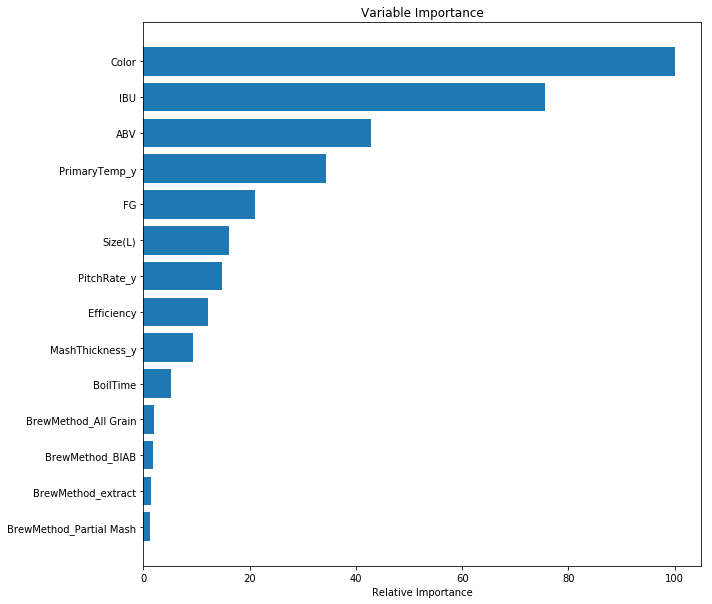

In [45]:
#random forest classifier feature importance
rfc.fit(X,y)
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize =(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [46]:
# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [47]:
#gradient boosting classifier

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params,subsample=.5)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)



In [48]:
#gradient boosting scores
score = accuracy_score(y_train, predict_train, normalize=True, sample_weight=None)
print("Train {}".format(score))
score2 = accuracy_score(y_test, predict_test, normalize=True, sample_weight=None)
print("Test {}".format(score2))

Train 0.8322398742070162
Test 0.7850791585339406


Text(0.5,0,'Category')

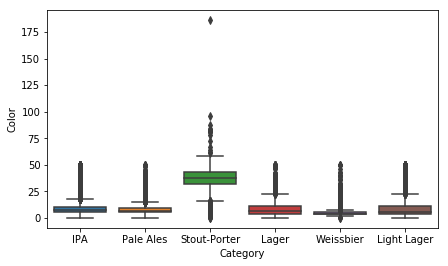

In [49]:
#plot important features
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x = 'kind', y = 'Color', data = beer4)
ax.set_xlabel('Category')

Text(0.5,0,'Category')

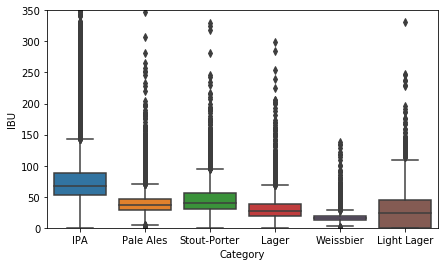

In [50]:
#plot important features
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x = 'kind', y = 'IBU', data = beer4)
plt.ylim(0,350)
ax.set_xlabel('Category')
#Outliers cut off for better visualization

(0, 20)

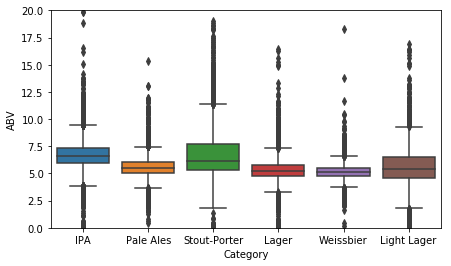

In [51]:
#plot important features
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x = 'kind', y = 'ABV', data = beer4)
ax.set_xlabel('Category')
plt.ylim(0,20)
#Outliers cut off for better visualization

(0, 60)

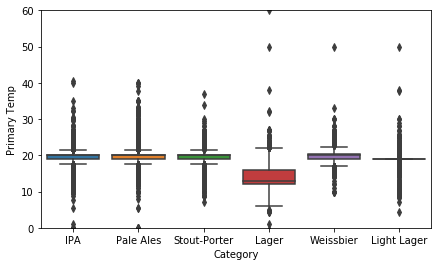

In [52]:
#plot important features
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x = 'kind', y = 'PrimaryTemp_y', data = beer4)
ax.set_xlabel('Category')
ax.set_ylabel('Primary Temp')
plt.ylim(0,60)
#Outliers cut off for better visualization

Now I'd like to do a binary classification with Stout and Porter since I couldn't classify them in my multinomial classification.

In [53]:
#dropping unnecessary columns.
stout = beer.drop(columns = ['PrimingMethod','PrimingAmount','URL','Name','OG','BoilGravity','BoilSize','SugarScale'])

In [54]:
#find and group stout and porter
a = stout['Stout'] = (beer['Style'].str.contains(' Stout'))*'Stout'
b = stout['Porter'] = (beer['Style'].str.contains(' Porter'))*'Porter' 

In [55]:
#create kind of beer column
stout['kind'] = a+b+''

In [56]:
#cut unnecessary stout and porter columns
stout2 = cut_beercols(stout)

Stout     5954
Porter    2700
Name: kind, dtype: int64


In [57]:
#fill nan
stout3 = fill_median(stout2,columnlist,['Stout','Porter'])

In [58]:
stout3.head()

,Style,StyleID,Size(L),FG,ABV,IBU,Color,BoilTime,Efficiency,BrewMethod,BeerID,kind,PrimaryTemp_y,PitchRate_y,MashThickness_y
0,Robust Porter,129,22.71,1.016,5.77,31.63,34.76,75,73.0,All Grain,9,Porter,20.0,0.0,1.0
1,Robust Porter,129,50.00,1.014,5.76,39.00,38.71,60,71.0,All Grain,30,Porter,18.0,0.0,1.0
2,Robust Porter,129,22.71,1.012,5.38,0.00,46.10,60,72.0,All Grain,35,Porter,20.0,0.0,1.0
3,Oatmeal Stout,114,20.00,1.019,5.21,37.34,42.09,90,75.0,All Grain,47,Stout,19.0,0.0,1.0
4,Russian Imperial Stout,132,20.00,1.025,9.67,69.25,50.00,90,65.0,All Grain,59,Stout,18.0,1.0,1.0


In [59]:
#pre-processing
scaled_df = preproc(stout3,['Style','StyleID','BeerID','kind'])

Index(['Size(L)', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency',
       'PrimaryTemp_y', 'PitchRate_y', 'MashThickness_y',
       'BrewMethod_All Grain', 'BrewMethod_BIAB', 'BrewMethod_Partial Mash',
       'BrewMethod_extract'],
      dtype='object')


In [60]:
#logistic regression
y = np.ravel(stout3['kind'])
y = y.astype(str)
X = np.asarray(scaled_df)
# Declare a logistic regression classifier.
lr = LogisticRegression(C = 1e6)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20)
##Fit the model.
fit = lr.fit(X_train, Y_train)

In [61]:
#logistic regression output
print('Coefficients') 
print(fit.coef_)
print('Intercepts')
print (fit.intercept_)
pred_y_sklearn = lr.predict(X_test)
pred_y_sklearn = lr.predict(X_train)
print('\n Percentage accuracy')
print('Test',lr.score(X_test, Y_test))
print('Train',lr.score(X_train, Y_train))

Coefficients
[[-1.66715588  0.65048639  1.5954927  32.52041593 16.43548572  0.28853055
   0.24996998  3.18046126 -0.19030753  3.92281145 -1.12499496 -0.99058731
  -0.71081593 -0.71912076]]
Intercepts
[-3.54551896]

 Percentage accuracy
Test 0.7267475447718083
Train 0.7319081323125812


In [62]:
#random forest classifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
rfc = ensemble.RandomForestClassifier(n_jobs = -1)
y = np.ravel(stout3['kind'])
X = pd.DataFrame(scaled_df)
cross_val_score(rfc,X,y,cv=5)

array([0.75563258, 0.74465627, 0.71403813, 0.72385904, 0.71791908])

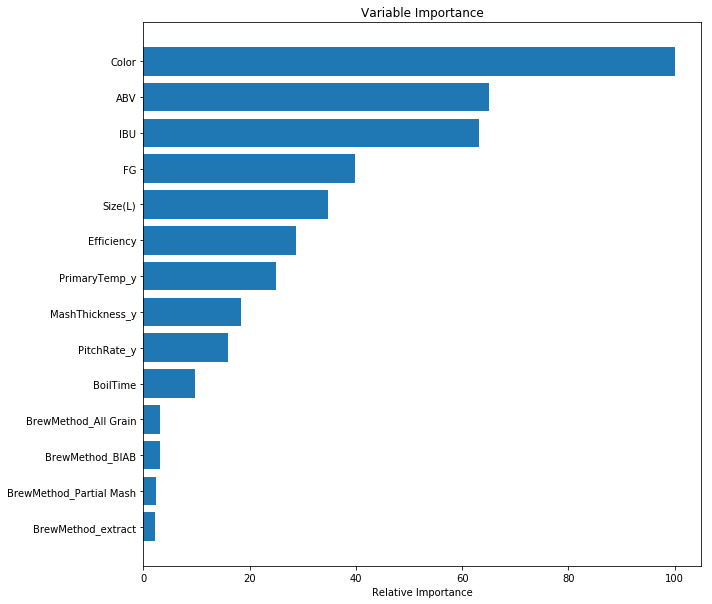

In [63]:
#rfc feature importance
rfc.fit(X,y)
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize =(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [64]:
# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [65]:
# gradient boosting classifier
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params,subsample=.5)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)



In [66]:
#gradient boosting scores
score = accuracy_score(y_train, predict_train, normalize=True, sample_weight=None)
print("Train {}".format(score))
score2 = accuracy_score(y_test, predict_test, normalize=True, sample_weight=None)
print("Test {}".format(score2))


Train 0.8051422793586596
Test 0.7354130560369728


In [67]:
#dropping unnecessary columns.
IPA = beer.drop(columns = ['PrimingMethod','PrimingAmount','URL','Name','OG','BoilGravity','BoilSize','SugarScale'])

In [68]:
#find and group stout and porter
y = IPA['IPA'] = (beer['Style'].str.contains(' IPA'))*'IPA'
z = IPA['Pale Ale'] = (beer['Style'].str.contains('Saison|Strong Bitter|Pale Ale'))*'Pale Ales'

In [69]:
#create kind of beer column
IPA['kind'] = y+z+''

In [70]:
#cut unnecessary IPA and Pale Ale columns
IPA2 = cut_beercols(IPA)

IPA          17064
Pale Ales    11963
Name: kind, dtype: int64


In [71]:
#fill nan
IPA3 = fill_median(IPA2,columnlist,['IPA','Pale Ales'])

In [72]:
#preprocessing
scaled_df = preproc(IPA3,['Style','StyleID','BeerID','kind'])

Index(['Size(L)', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency',
       'PrimaryTemp_y', 'PitchRate_y', 'MashThickness_y',
       'BrewMethod_All Grain', 'BrewMethod_BIAB', 'BrewMethod_Partial Mash',
       'BrewMethod_extract'],
      dtype='object')


In [73]:
#logistic regression
y = np.ravel(IPA3['kind'])
y = y.astype(str)
X = np.asarray(scaled_df)
# Declare a logistic regression classifier.
lr = LogisticRegression(C = 1e6)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20)
##Fit the model.
fit = lr.fit(X_train, Y_train)

In [74]:
#logistic regression output
print('Coefficients') 
print(fit.coef_)
print('Intercepts')
print (fit.intercept_)
pred_y_sklearn = lr.predict(X_test)
pred_y_sklearn = lr.predict(X_train)
print('\n Percentage accuracy')
print('Test',lr.score(X_test, Y_test))
print('Train',lr.score(X_train, Y_train))

Coefficients
[[-2.61734646e+00 -5.68673971e-01 -4.03602312e+01 -9.59542398e+01
  -2.21675975e+00  1.42312608e+00  1.35113108e+00  6.52169684e+00
   3.27860906e-02  3.12466330e-01  4.56612375e-01  6.06079659e-01
   6.33173082e-01  8.92029696e-01]]
Intercepts
[2.58789481]

 Percentage accuracy
Test 0.8193248363761626
Train 0.8186555273244046


In [75]:
#random forest classifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
rfc = ensemble.RandomForestClassifier(n_jobs = -1)
y = np.ravel(IPA3['kind'])
X = pd.DataFrame(scaled_df)
cross_val_score(rfc,X,y,cv=5)

array([0.83344816, 0.8269032 , 0.8138133 , 0.82273902, 0.80444521])

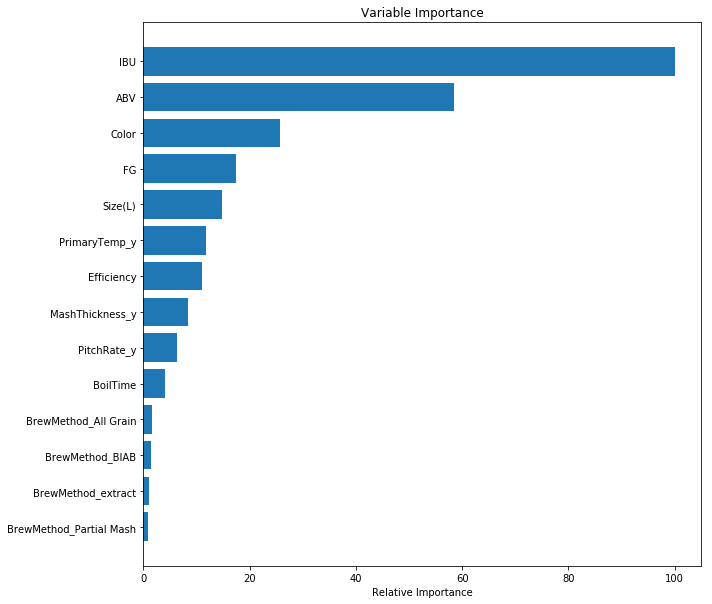

In [76]:
# rfc feature importance
rfc.fit(X,y)
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize =(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [77]:
# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [78]:
# Gradient boosting classifier
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params,subsample=.5)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)



In [79]:
#gradient boosting scores
score = accuracy_score(y_train, predict_train, normalize=True, sample_weight=None)
print("Train {}".format(score))
score2 = accuracy_score(y_test, predict_test, normalize=True, sample_weight=None)
print("Test {}".format(score2))

Train 0.854054519615865
Test 0.8114019979331726
